In [92]:
import torch
import gpytorch as gp

import numpy as np
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

import yfinance as yf
import pandas_datareader.data as web

from typing import Tuple
import datetime

In [93]:
def get_closing_price_from_yfinance( 
        ticker_symbol : str, 
        start_date : datetime.datetime, 
        end_date : datetime.datetime
        ) -> pd.DataFrame:
    """
    Returns a pandas dataframe of the closing prices for a given stock ticker

    Arguments:
    ---------- 
    ticker_symbol   : {string}
                        > The stock ticker symbol 
    start_date      : {datetime.datetime}
                        > The start date of the data
    end_date        : {datetime.datetime}  
                        > The end date of the data
    
    Returns:
    ----------
    df              : {pandas.DataFrame}
                        > A pandas dataframe of the closing prices for the given stock ticker
    """
    # get data
    df = yf.download(ticker_symbol, start_date, end_date)

    # adjust index
    df.index = df.index.date
    
    
    return pd.DataFrame(df['Adj Close'])

[*********************100%***********************]  1 of 1 completed


''

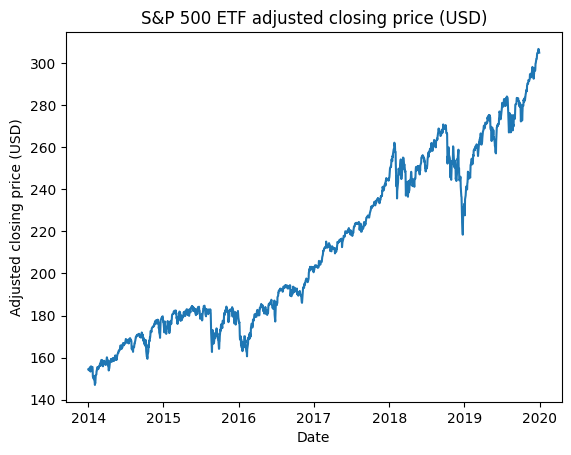

In [94]:
# download data
ticker_symbol = 'SPY'
start_date = datetime.datetime(2014, 1, 1)
end_date = datetime.datetime(2019, 12, 31)

sp_500_etf_close = get_closing_price_from_yfinance(ticker_symbol, start_date, end_date)

# plot data
plt.plot(sp_500_etf_close)
plt.title('S&P 500 ETF adjusted closing price (USD)')
plt.xlabel('Date')
plt.ylabel('Adjusted closing price (USD)')
;

In [107]:
train_data = sp_500_etf_close[-20:-10]

In [164]:
def normalise_data(
        df : pd.DataFrame
    ) -> pd.DataFrame:
    """
    Returns a pandas dataframe of the normalised data

    Arguments:
    ---------- 
    df              : {pandas.DataFrame}
                        > A pandas dataframe of the data to be normalised
    
    Returns:
    ----------
    df              : {pandas.DataFrame}
                        > A pandas dataframe of the normalised data
    """
    # normalise data
    df = (df - df.mean()) / df.std()
    
    return df

In [165]:
y_train = normalise_data(train_data).values
x_train = np.arange(len(y_train))

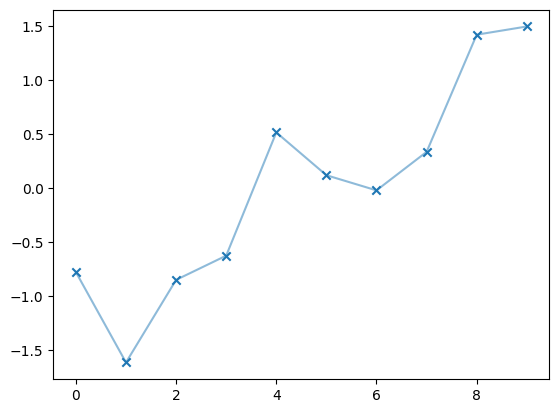

In [166]:
plt.scatter(x_train, y_train, marker='x', label='Training data', alpha = 1)
plt.plot(x_train, y_train, alpha = 0.5)

In [167]:
# make GP class
class ExactGPModel(gp.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gp.means.ConstantMean()
        self.covar_module = gp.kernels.ScaleKernel(gp.kernels.RBFKernel())
    
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gp.distributions.MultivariateNormal(mean_x, covar_x)

In [168]:
# initialize likelihood and model
likelihood = gp.likelihoods.GaussianLikelihood()

In [169]:
# convert to tensors
x_train = torch.from_numpy(x_train).float()
y_train = torch.from_numpy(y_train).float().squeeze()

In [170]:
# instantiate model
model = ExactGPModel(x_train, y_train, likelihood)

In [209]:
# update lengthscale and noise
model.covar_module.base_kernel.lengthscale = torch.tensor(0.5)
model.likelihood.noise = torch.tensor(0.0001)

In [210]:
# define x_test
x_test = torch.linspace(0, 10, 100)

In [211]:
# get posterior
model.eval()
with torch.no_grad(), gp.settings.fast_pred_var():
    f_preds = model(x_test)
    y_preds = likelihood(model(x_test))

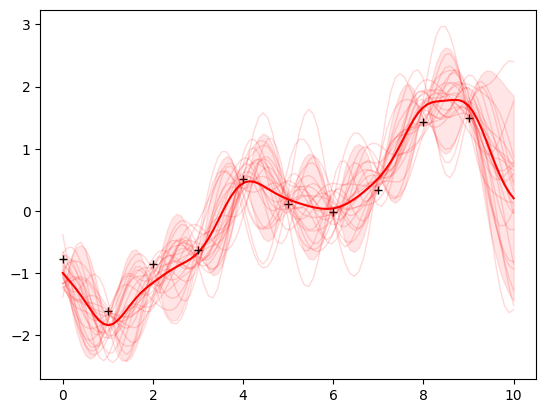

In [221]:
plt.plot(x_test, f_preds.mean, label='GP mean', color='red')
plt.plot(x_train, y_train, '+', label='Training data', color='black')

for i in range(25):
    f_samples = f_preds.rsample()
    plt.plot(x_test, f_samples, lw=1, alpha=0.15, color='red')

upper, lower = f_preds.confidence_region()

plt.fill_between(x_test, lower, upper, alpha=0.1, color='red')

In [320]:
data = sp_500_etf_close[-200:]
y_data = normalise_data(data).values
x_data = np.arange(len(y_data))

x_train = torch.from_numpy(x_data[-200:-50]).float()
y_train = torch.from_numpy(y_data[-200:-50]).float().squeeze()

x_test = torch.from_numpy(x_data[-50:]).float()
y_test = torch.from_numpy(y_data[-50:]).float().squeeze()

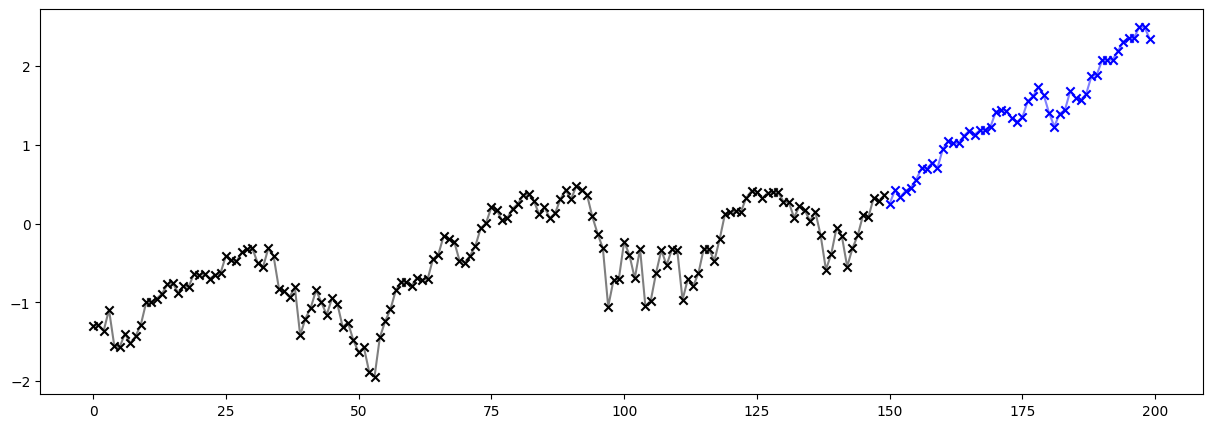

In [321]:
plt.figure(figsize=(15, 5))

# train data
plt.scatter(x_train, y_train, marker='x', label='Training data', alpha = 1, color='black')
plt.plot(x_train, y_train, alpha = 0.5, color='black')

# test data
plt.scatter(x_test, y_test, marker='x', label='Test data', alpha = 1, color='blue')
plt.plot(x_test, y_test, alpha = 0.5, color='blue')

In [322]:
# create the GP model

# instantiate model
model = ExactGPModel(x_train, y_train, likelihood)

# set hyperparameters
# update lengthscale and noise
model.covar_module.base_kernel.lengthscale = torch.tensor(5)
model.likelihood.noise = torch.tensor(0.05)

In [324]:
# define x_test
x_range = torch.linspace(0, len(x_train)+len(x_test), 1000)

In [327]:
# get posterior
model.eval()
with torch.no_grad(), gp.settings.fast_pred_var():
    f_preds = model(x_range)
    y_preds = likelihood(model(x_range))

In [1]:
plt.figure(figsize=(15, 5))

plt.plot(x_range, f_preds.mean, label='GP mean', color='red', lw=0.5)
plt.plot(x_train, y_train, '+', label='Training data', color='black')

for i in range(25):
    f_samples = f_preds.rsample()
    plt.plot(x_range, f_samples, lw=.25, alpha=.25, color='red')

upper, lower = f_preds.confidence_region()

plt.fill_between(x_range, lower, upper, alpha=0.1, color='red')

plt.plot(x_train, y_train, color = 'black', lw = 1, alpha = 0.5)

plt.scatter(x_test, y_test, marker='+', label='Test data', alpha = 1, color='blue', lw=.5)
plt.plot(x_test, y_test, alpha = 0.5, color='blue')

NameError: name 'plt' is not defined